In [1]:
!pip install pydub
import pydub

In [2]:
!pip install simpleaudio
import simpleaudio

In [3]:
import numpy as np              # essential math library
import matplotlib.pyplot as plt # to plot things
from pydub import AudioSegment  # working with audio
import scipy.signal             # signal processing library
import soundfile as sf
from google.colab import files
import simpleaudio as sa        # to play sound https://simpleaudio.readthedocs.io/en/latest
rng1 = np.random.default_rng() # used to generate random signals


In [4]:
sound1 = AudioSegment.from_wav('/content/Gsp_ME_p_L-sus_F#5.wav')
sound1 = sound1.set_channels(1)
# convert the 16-bit samples in [-32768,32768) to floating point numbers in [-1,1)
ydata1 = sound1.get_array_of_samples()/(np.power(2,16)/2)

sound2 = AudioSegment.from_wav('/content/Gsp_ME_f_L-sus_F#6.wav')
sound2 = sound2.set_channels(1)
# convert the 16-bit samples in [-32768,32768) to floating point numbers in [-1,1)
ydata2 = sound2.get_array_of_samples()/(np.power(2,16)/2)

# 1. Plot the time domain waveforms

Plot the entire time-domain waveform of sound1(F#5_p).

1


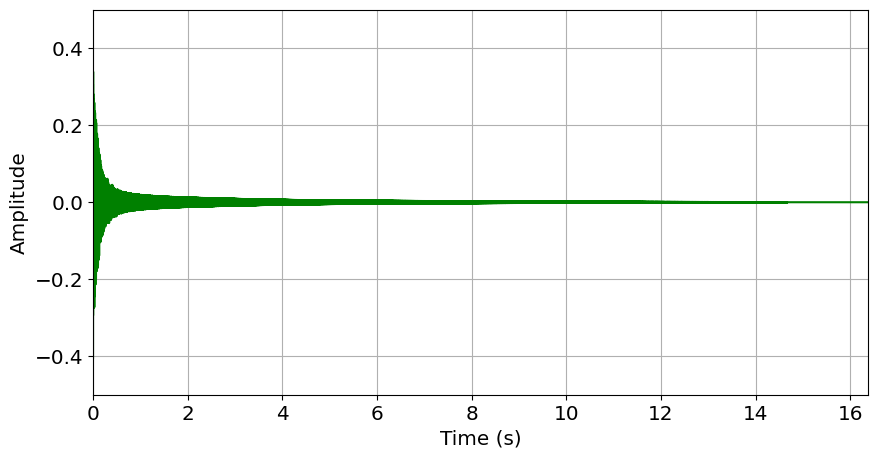

In [5]:
params = {'legend.fontsize': 'x-large','figure.figsize': (10, 5),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)
fig, ax = plt.subplots()

times1 = np.arange(len(ydata1))/(sound1.frame_rate) # time position of each sample index
print(sound1.channels)

plt.plot(times1,ydata1,color="green")
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.xlim((0,times1[-1])); plt.ylim((-0.5,0.5))
ax.grid()
plt.show()

Plot the entire time-domain waveform of sound2 (F#6_f).

1


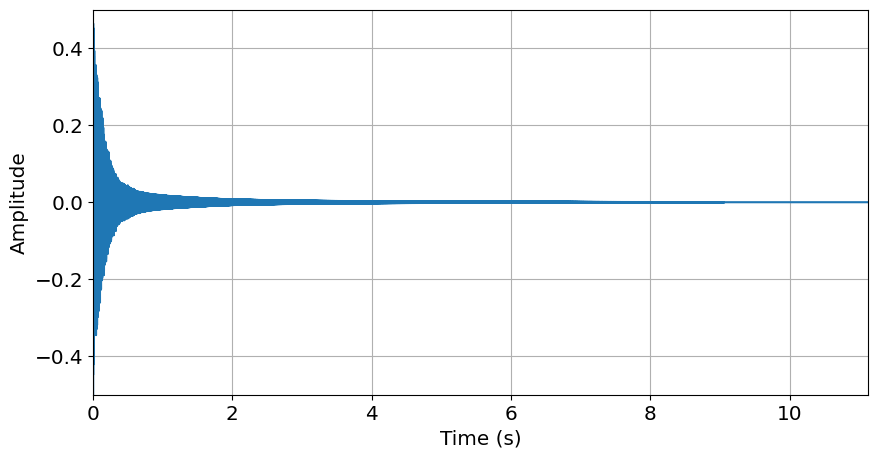

In [6]:
params = {'legend.fontsize': 'x-large','figure.figsize': (10, 5),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)
fig, ax = plt.subplots()

times2 = np.arange(len(ydata2))/(sound2.frame_rate) # time position of each sample index
print(sound2.channels)

plt.plot(times2,ydata2)
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.xlim((0,times2[-1])); plt.ylim((-0.5,0.5))
ax.grid()
plt.show()

To do this we take the Fourier transform and take care of the conversion from frequency indices to frequency in Hz. We also do two important things: 1) We apply a window function to shape the ends of the segment; 2) We sample the Fourier transform at many more points than are in the segment (essentially zero padding). These together make a smoother magnitude spectrum.

# Sound1/ Plot the magnitude spectra and locate the partials below 15kHz having the most energy

*The magnitude spectra:*

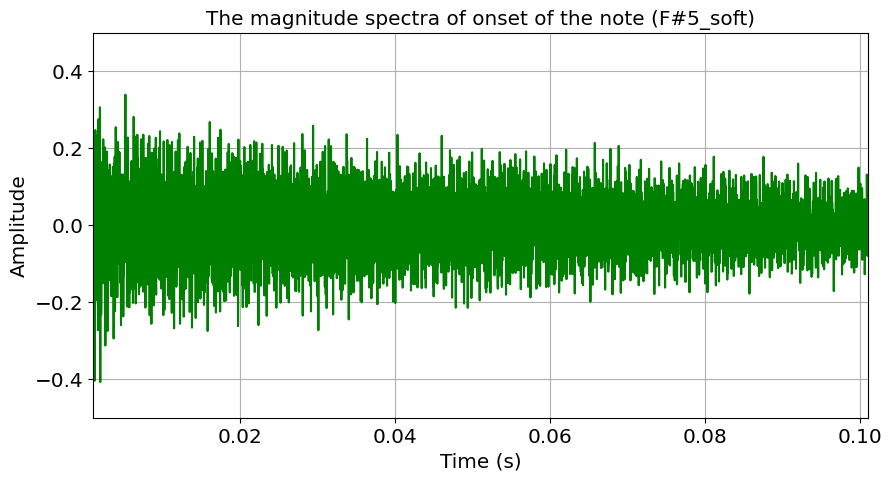

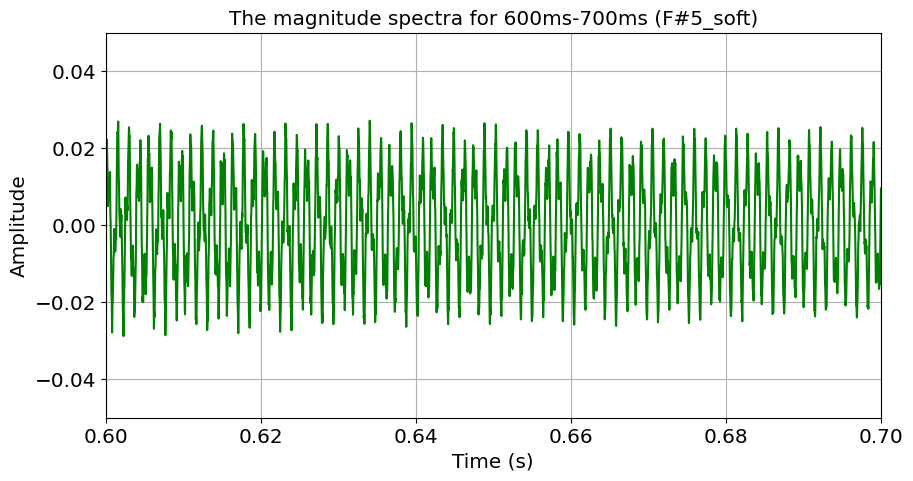

In [11]:
#The magnitude spectra 1ms-101ms
windowlen_seconds = 100/1000   # Using a rectangular window of fixed size 100ms
timetotakewindow_seconds1 = 1/1000  # start from onset of the note (1ms)
fig, ax = plt.subplots()
plt.plot(times1,ydata1,color="Green")
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.xlim((timetotakewindow_seconds1,timetotakewindow_seconds1+windowlen_seconds))
plt.ylim((-0.5,0.5))
plt.title("The magnitude spectra of onset of the note (F#5_soft)")
ax.grid();
plt.show()

#The magnitude spectra 600ms-700ms
timetotakewindow_seconds600 = 600/1000  # start from 600ms
fig, ax = plt.subplots()
plt.plot(times1,ydata1,color="Green")
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.xlim((timetotakewindow_seconds600,timetotakewindow_seconds600+windowlen_seconds))
plt.ylim((-0.05,0.05))
plt.title("The magnitude spectra for 600ms-700ms (F#5_soft)")
ax.grid();
plt.show()

Locate the partials below 15kHz having the most energy for sound1:

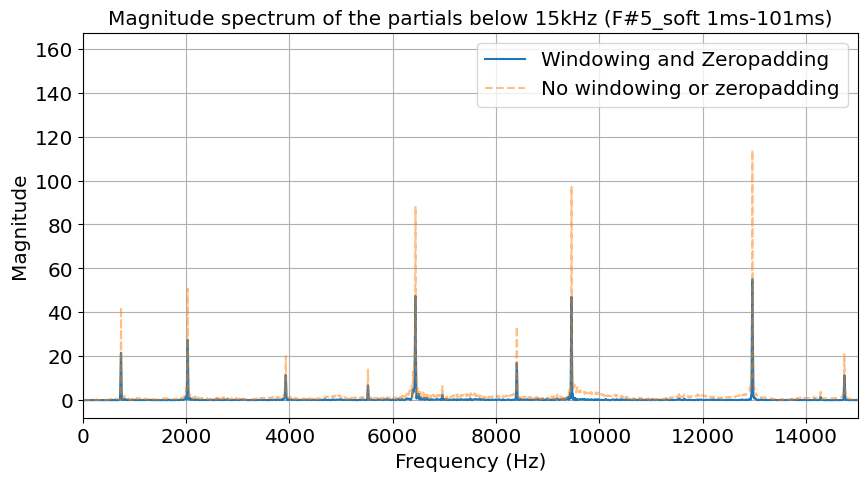

The max energy: 83 and its frequency is 6245Hz.


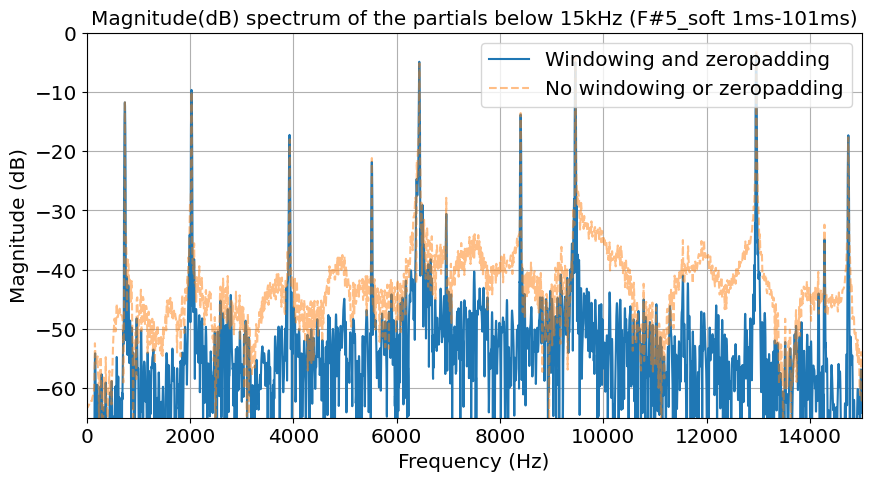

The max energy: 0dB and its frequency is 6245Hz.



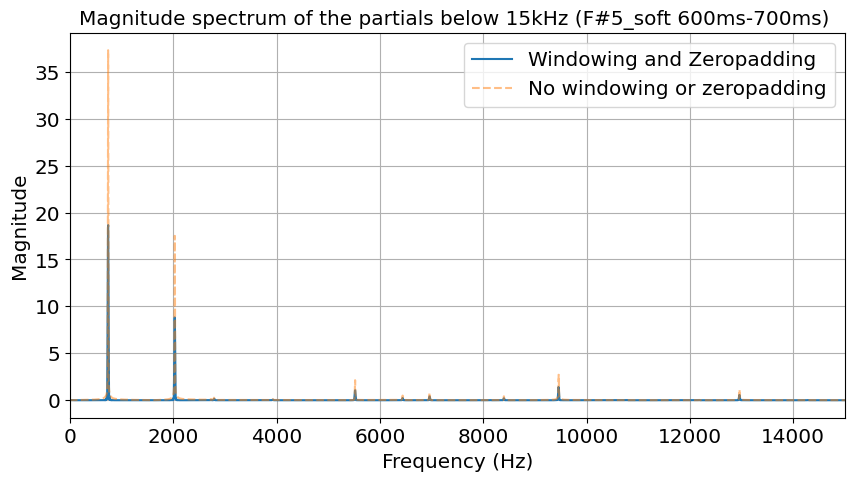

The max energy: 18 and its frequency is 275Hz.



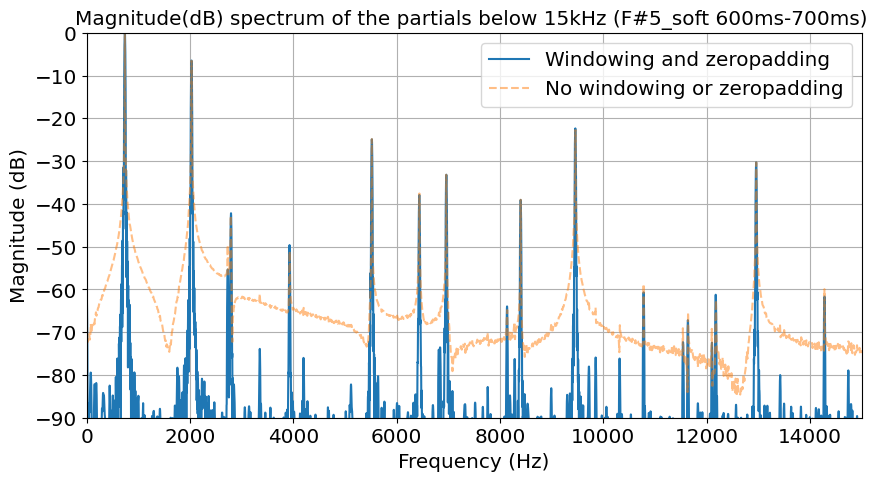

The max energy: 0dB and its frequency is 275Hz.



In [12]:
# The first segment from [0,15] kHz:
windowlen_samples = int(windowlen_seconds*sound1.frame_rate)
timetotakewindow_samples = int(timetotakewindow_seconds1*sound1.frame_rate)
# The following takes the Fourier transform of the 100 ms segment of sound
YDATA_nowindoworZP = \
    np.fft.fft(ydata1[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples])
# Shapes the segment with a Hann window and "zero pads" it
YDATA = np.fft.fft(np.hanning(windowlen_samples)* \
                   ydata1[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples], \
                n=8192*2)
fig, ax = plt.subplots()
freqs = sound1.frame_rate*np.arange(len(YDATA))/len(YDATA) # frequency (Hz) of each Fourier sample index
plt.plot(freqs,np.abs(YDATA),'-')
freqs = sound1.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,np.abs(YDATA_nowindoworZP),'--',alpha=0.5)

plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude')
plt.legend(['Windowing and Zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000))
plt.title("Magnitude spectrum of the partials below 15kHz (F#5_soft 1ms-101ms)")
ax.grid();
plt.show()
print('The max energy: %d and its frequency is %dHz.'%(np.abs(YDATA).max(),np.abs(YDATA).argmax()))



# dB magnitude spectrum of the first segment to find the value to filter (-42dB)
YDATAdB = 20*np.log10(np.abs(YDATA)/np.max(np.abs(YDATA)))
YDATA_nowindoworZPdB = 20*np.log10(np.abs(YDATA_nowindoworZP)/np.max(np.abs(YDATA_nowindoworZP)))

fig, ax = plt.subplots()
freqs = sound1.frame_rate*np.arange(len(YDATA))/len(YDATA) # frequency (Hz) of each Fourier sample index
plt.plot(freqs,YDATAdB,'-')
freqs = sound1.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,YDATA_nowindoworZPdB,'--',alpha=0.5)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude (dB)')
plt.legend(['Windowing and zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000)); plt.ylim((-65,0))
plt.title("Magnitude(dB) spectrum of the partials below 15kHz (F#5_soft 1ms-101ms)")
ax.grid();
plt.show()
# The most energy, frequencies and amplitudes
print('The max energy: %ddB and its frequency is %dHz.'%(YDATAdB.max(),YDATAdB.argmax()))
print()




# The second segment from [0,15] kHz:
timetotakewindow_samples = int(timetotakewindow_seconds600*sound1.frame_rate)
# The following takes the Fourier transform of the 600 ms segment of sound
YDATA_nowindoworZP = \
    np.fft.fft(ydata1[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples])
# Shapes the segment with a Hann window and "zero pads" it
YDATA = np.fft.fft(np.hanning(windowlen_samples)* \
                   ydata1[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples], \
                n=8192*2)

fig, ax = plt.subplots()
freqs = sound1.frame_rate*np.arange(len(YDATA))/len(YDATA) # frequency (Hz) of each Fourier sample index
plt.plot(freqs,np.abs(YDATA),'-')

freqs = sound1.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,np.abs(YDATA_nowindoworZP),'--',alpha=0.5)

plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude')
plt.legend(['Windowing and Zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000))
plt.title("Magnitude spectrum of the partials below 15kHz (F#5_soft 600ms-700ms) ")
ax.grid();
plt.show()
## The most energy, frequencies and amplitudes
print('The max energy: %d and its frequency is %dHz.'%(np.abs(YDATA).max(),np.abs(YDATA).argmax()))
print()

# dB magnitude spectrum of the second segment to find the value to filter (-72dB)
YDATAdB = 20*np.log10(np.abs(YDATA)/np.max(np.abs(YDATA)))
YDATA_nowindoworZPdB = 20*np.log10(np.abs(YDATA_nowindoworZP)/np.max(np.abs(YDATA_nowindoworZP)))

fig, ax = plt.subplots()
freqs = sound1.frame_rate*np.arange(len(YDATA))/len(YDATA) # frequency (Hz) of each Fourier sample index
plt.plot(freqs,YDATAdB,'-')
freqs = sound1.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,YDATA_nowindoworZPdB,'--',alpha=0.5)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude (dB)')
plt.legend(['Windowing and zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000)); plt.ylim((-90,0))
plt.title("Magnitude(dB) spectrum of the partials below 15kHz (F#5_soft 600ms-700ms) ")
ax.grid();
plt.show()
# The most energy, frequencies and amplitudes
print('The max energy: %ddB and its frequency is %dHz.'%(YDATAdB.max(),YDATAdB.argmax()))
print()


# *Sound1*/ Plot the amplitude envelopes

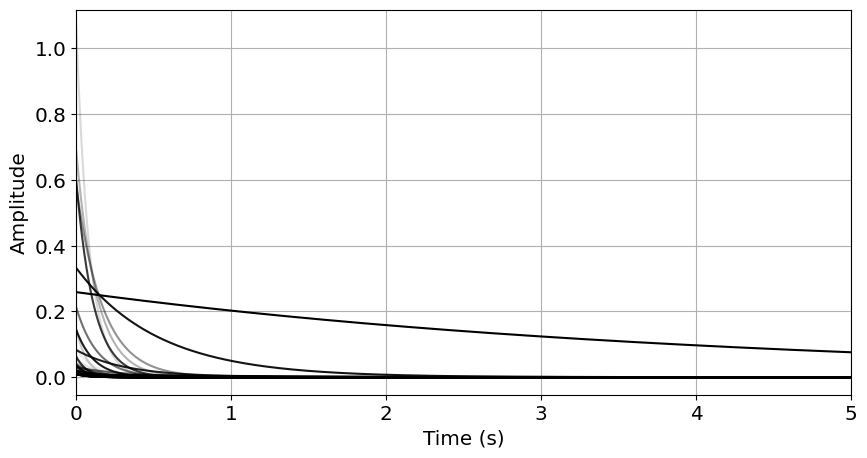

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
windowlen_seconds = 100/1000
time1totakewindow_seconds = 1/1000
time2totakewindow_seconds = time1totakewindow_seconds + 600/1000

time1totakewindow_samples = int(time1totakewindow_seconds*sound1.frame_rate)
time2totakewindow_samples = int(time2totakewindow_seconds*sound1.frame_rate)

Y1DATA = np.fft.fft(np.hanning(windowlen_samples)*ydata1[time1totakewindow_samples:time1totakewindow_samples+windowlen_samples],
                n=8192*2)
Y2DATA = np.fft.fft(np.hanning(windowlen_samples)*ydata1[time2totakewindow_samples:time2totakewindow_samples+windowlen_samples],
                n=8192*2)

Y1DATAdB = 20*np.log10(np.abs(Y1DATA)/np.max(np.abs(Y1DATA)))
Y2DATAdB = 20*np.log10(np.abs(Y2DATA)/np.max(np.abs(Y1DATA)))
peaks, props = scipy.signal.find_peaks(Y1DATAdB[0:int(len(Y1DATAdB)/2)], height=-42) # -42dB from Magnitude(dB) Spectrum
freqs = np.arange(len(Y1DATA))/len(Y1DATA)*sound1.frame_rate

fig, ax = plt.subplots()
counter = 0
for ii in peaks:
    amp1 = Y1DATAdB[ii]
    amp2 = Y2DATAdB[ii]
    gamma = (np.log(10)/20)*(amp1-amp2)/(time2totakewindow_seconds-time1totakewindow_seconds)
    A = np.power(10,amp1/20)*np.power(10,gamma*time1totakewindow_seconds/np.log10(np.exp(1)))
    et = np.arange(0,5*sound1.frame_rate)/sound1.frame_rate
    envelope = A*np.exp(-gamma*et)
    plt.plot(et,envelope,color='k',alpha=1-(counter/(len(peaks)+1)))
    counter += 1

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim((0,5))
ax.grid();
plt.show()

tonedur = 3
N = int(tonedur*sound1.frame_rate)
n = np.arange(N)
ysum = np.zeros((N,))
# Transposing all the pitches
ysum1 = np.zeros((N,))
ysum2 = np.zeros((N,))
ysum3 = np.zeros((N,))
ysum4 = np.zeros((N,))

for ii in peaks:
    amp1 = Y1DATAdB[ii]
    amp2 = Y2DATAdB[ii]
    gamma = (np.log(10)/20)*(amp1-amp2)/(time2totakewindow_seconds-time1totakewindow_seconds)
    A = np.power(10,amp1/20)*np.power(10,gamma*time1totakewindow_seconds/np.log10(np.exp(1)))
    t = np.arange(0,tonedur*sound1.frame_rate)
    envelope = A*np.exp(-gamma*t/sound1.frame_rate)
    ysum += envelope*np.cos(2*np.pi*freqs[ii]*n/sound1.frame_rate
                    + np.angle(YDATA[ii]))
    ysum1 += envelope*np.cos(2*np.pi*freqs[ii]*n*2/sound1.frame_rate
                    + np.angle(YDATA[ii]))
    ysum2 += envelope*np.cos(2*np.pi*freqs[ii]*n*2.5/sound1.frame_rate
                    + np.angle(YDATA[ii]))
    ysum3 += envelope*np.cos(2*np.pi*freqs[ii]*n*0.5/sound1.frame_rate
                    + np.angle(YDATA[ii]))


ysum /= np.max(np.abs(ysum)) # normalize
ysum = np.concatenate((ydata1[0:len(ysum)],ysum)) #The first segment of the output audio 'ydata1[0:len(ysum)]'
#ysum = np.concatenate((ysum,ysum1,ysum2,ysum3))
ysum_scaled = np.int16(ysum / np.max(np.abs(ysum)) * (np.power(2,16)/2)) # make 16-bit

# output sound
#sf.write('F#5_p.wav', ysum_scaled, sound1.frame_rate, subtype='PCM_16')
#files.download('F#5_p.wav')
#sf.write('Melody_sound11.wav', ysum_scaled, sound1.frame_rate, subtype='PCM_16')
#files.download('Melody_sound11.wav')

# *Sound2*/ Plot the magnitude spectra and locate the partials below 15kHz having the most energy

*The magnitude spectra:*

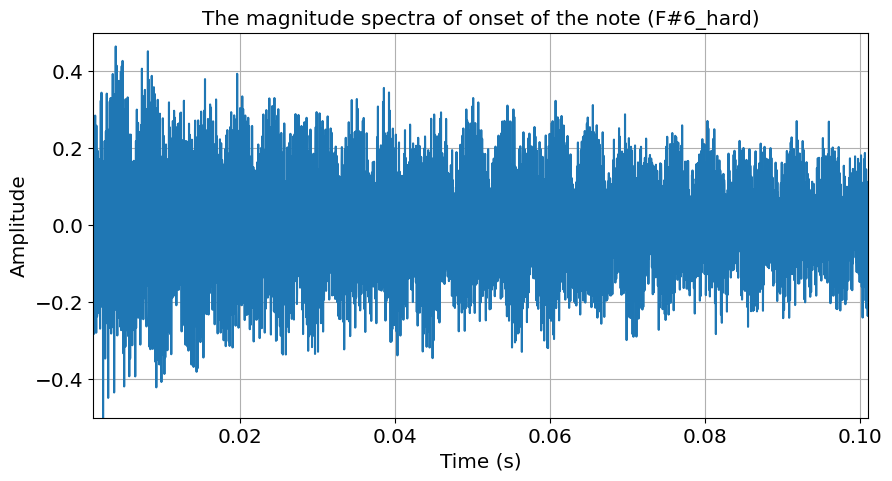

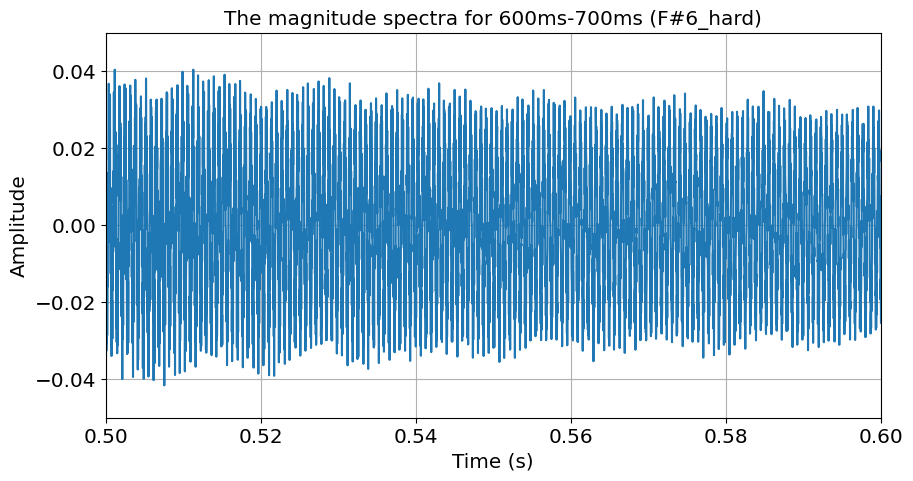

In [11]:
windowlen_seconds = 100/1000
timetotakewindow_seconds1 = 1/1000

fig, ax = plt.subplots()
plt.plot(times2,ydata2)
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.xlim((timetotakewindow_seconds1,timetotakewindow_seconds1+windowlen_seconds))
plt.ylim((-0.5,0.5))
plt.title("The magnitude spectra of onset of the note (F#6_hard)")
ax.grid();
plt.show()

timetotakewindow_seconds500 = 500/1000
fig, ax = plt.subplots()
plt.plot(times2,ydata2)
plt.xlabel('Time (s)'); plt.ylabel('Amplitude')
plt.xlim((timetotakewindow_seconds500,timetotakewindow_seconds500+windowlen_seconds))
plt.ylim((-0.05,0.05))
plt.title("The magnitude spectra for 600ms-700ms (F#6_hard)")
ax.grid();
plt.show()

Locate the partials below 15kHz having the most energy for sound2:

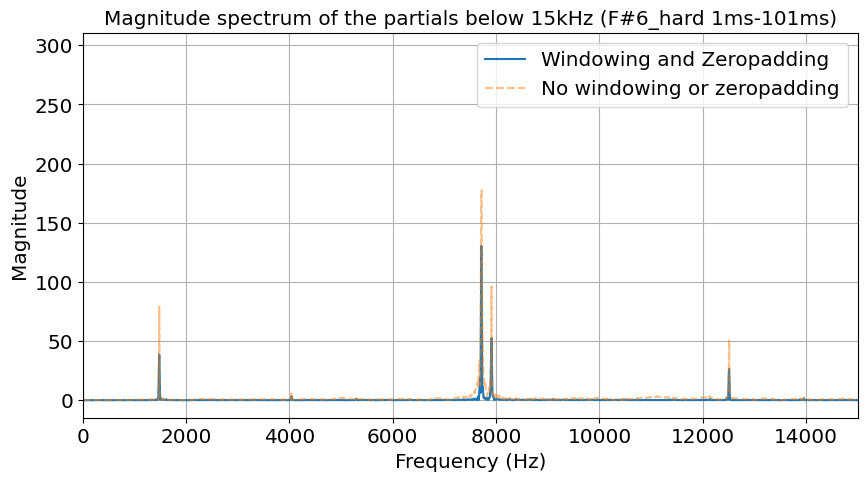

The max energy: 147 and its frequency is 6710Hz.



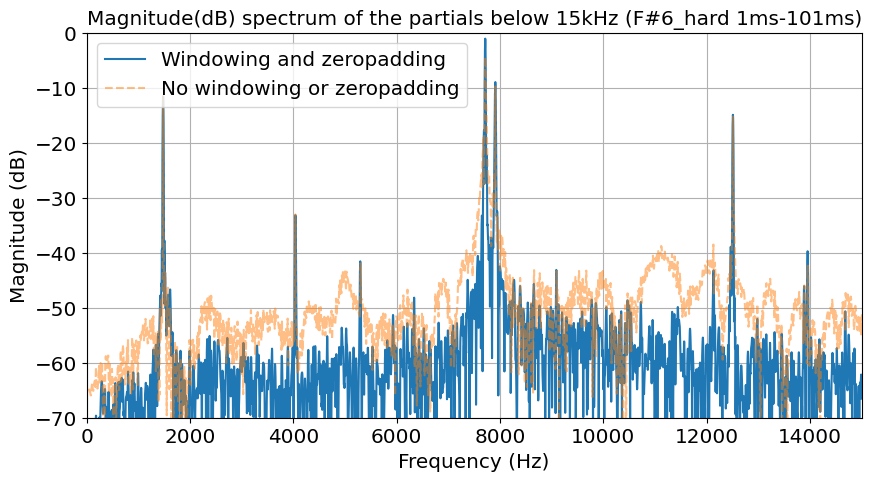

The max energy: 0dB and its frequency is 6710Hz.



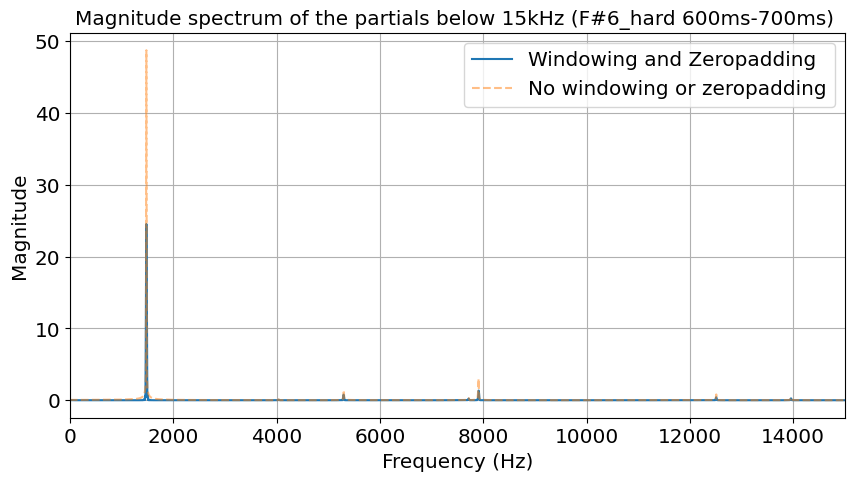

The max energy: 24 and its frequency is 15834Hz.


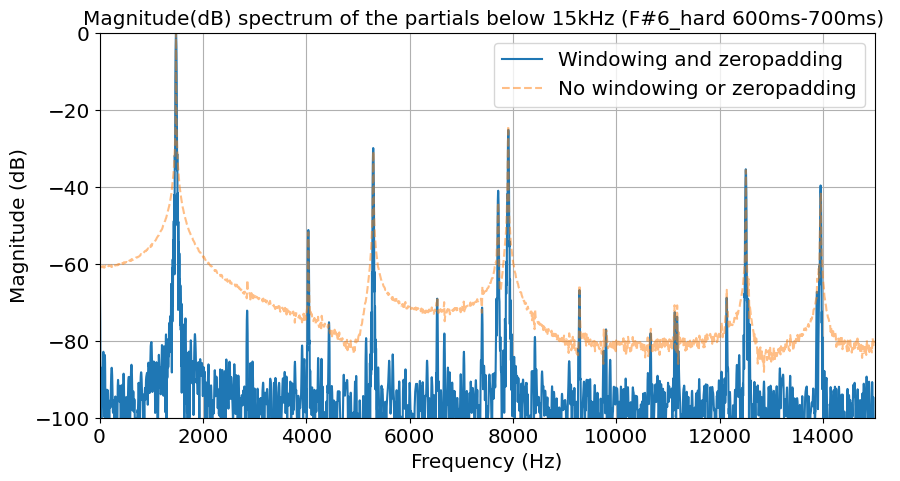

The max energy: 0dB and its frequency is 15834Hz.



In [12]:
# The first segment from [0,15] kHz:
windowlen_samples = int(windowlen_seconds*sound2.frame_rate)
timetotakewindow_samples = int(timetotakewindow_seconds1*sound2.frame_rate)
# The following takes the Fourier transform of the 100 ms segment of sound
YDATA_nowindoworZP = \
    np.fft.fft(ydata2[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples])
# Shapes the segment with a Hann window and "zero pads" it
YDATA = np.fft.fft(np.hanning(windowlen_samples)* \
                   ydata2[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples], \
                n=8192*2)
fig, ax = plt.subplots()

freqs = sound2.frame_rate*np.arange(len(YDATA))/len(YDATA)
plt.plot(freqs,np.abs(YDATA),'-')

freqs = sound2.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,np.abs(YDATA_nowindoworZP),'--',alpha=0.5)

plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude')
plt.legend(['Windowing and Zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000))
plt.title("Magnitude spectrum of the partials below 15kHz (F#6_hard 1ms-101ms)")
ax.grid();
plt.show()
## The most energy, frequencies and amplitudes
print('The max energy: %d and its frequency is %dHz.'%(np.abs(YDATA).max(),np.abs(YDATA).argmax()))
print()



# dB magnitude spectrum of the first segment to find the value to filter (-50dB)
YDATAdB = 20*np.log10(np.abs(YDATA)/np.max(np.abs(YDATA)))
YDATA_nowindoworZPdB = 20*np.log10(np.abs(YDATA_nowindoworZP)/np.max(np.abs(YDATA_nowindoworZP)))

fig, ax = plt.subplots()
freqs = sound2.frame_rate*np.arange(len(YDATA))/len(YDATA) # frequency (Hz) of each Fourier sample index
plt.plot(freqs,YDATAdB,'-')
freqs = sound2.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,YDATA_nowindoworZPdB,'--',alpha=0.5)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude (dB)')
plt.legend(['Windowing and zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000)); plt.ylim((-70,0))
plt.title("Magnitude(dB) spectrum of the partials below 15kHz (F#6_hard 1ms-101ms)")
ax.grid();
plt.show()
# The most energy, frequencies and amplitudes
print('The max energy: %ddB and its frequency is %dHz.'%(YDATAdB.max(),YDATAdB.argmax()))
print()



# The second segment from [0,15] kHz:
timetotakewindow_samples = int(timetotakewindow_seconds600*sound2.frame_rate)
# Takes the Fourier transform of the 600ms segment of sound
YDATA_nowindoworZP = \
    np.fft.fft(ydata2[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples])
# Shapes the segment with a Hann window to smooth the spectrum and "zero pads" it
YDATA = np.fft.fft(np.hanning(windowlen_samples)* \
                   ydata2[timetotakewindow_samples:timetotakewindow_samples+windowlen_samples], \
                n=8192*2)
fig, ax = plt.subplots()

freqs = sound2.frame_rate*np.arange(len(YDATA))/len(YDATA) # frequency (Hz) of each Fourier sample index
plt.plot(freqs,np.abs(YDATA),'-')

freqs = sound2.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,np.abs(YDATA_nowindoworZP),'--',alpha=0.5)

plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude')
plt.legend(['Windowing and Zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000))
plt.title("Magnitude spectrum of the partials below 15kHz (F#6_hard 600ms-700ms) ")
ax.grid();
plt.show()
# The most energy, frequencies and amplitudes
print('The max energy: %d and its frequency is %dHz.'%(np.abs(YDATA).max(),np.abs(YDATA).argmax()))



# dB magnitude spectrum of the second segment to find the value to filter (-65dB)
YDATAdB = 20*np.log10(np.abs(YDATA)/np.max(np.abs(YDATA)))
YDATA_nowindoworZPdB = 20*np.log10(np.abs(YDATA_nowindoworZP)/np.max(np.abs(YDATA_nowindoworZP)))

fig, ax = plt.subplots()
freqs = sound2.frame_rate*np.arange(len(YDATA))/len(YDATA) # frequency (Hz) of each Fourier sample index
plt.plot(freqs,YDATAdB,'-')
freqs = sound2.frame_rate*np.arange(len(YDATA_nowindoworZP))/len(YDATA_nowindoworZP)
plt.plot(freqs,YDATA_nowindoworZPdB,'--',alpha=0.5)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude (dB)')
plt.legend(['Windowing and zeropadding','No windowing or zeropadding'])
plt.xlim((0,15000)); plt.ylim((-100,0))
plt.title("Magnitude(dB) spectrum of the partials below 15kHz (F#6_hard 600ms-700ms) ")
ax.grid();
plt.show()
# The most energy, frequencies and amplitudes
print('The max energy: %ddB and its frequency is %dHz.'%(YDATAdB.max(),YDATAdB.argmax()))
print()

# *Sound2*/ Plot the amplitude envelopes

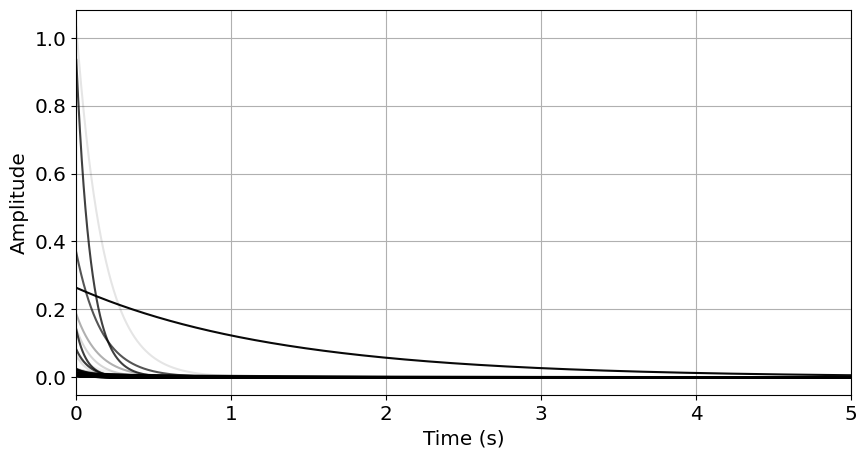

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
windowlen_seconds = 100/1000
time1totakewindow_seconds = 1/1000
time2totakewindow_seconds = time1totakewindow_seconds + 600/1000

time1totakewindow_samples = int(time1totakewindow_seconds*sound2.frame_rate)
time2totakewindow_samples = int(time2totakewindow_seconds*sound2.frame_rate)

Y1DATA = np.fft.fft(np.hanning(windowlen_samples)*ydata2[time1totakewindow_samples:time1totakewindow_samples+windowlen_samples],
                n=8192*2)
Y2DATA = np.fft.fft(np.hanning(windowlen_samples)*ydata2[time2totakewindow_samples:time2totakewindow_samples+windowlen_samples],
                n=8192*2)

Y1DATAdB = 20*np.log10(np.abs(Y1DATA)/np.max(np.abs(Y1DATA)))
Y2DATAdB = 20*np.log10(np.abs(Y2DATA)/np.max(np.abs(Y1DATA)))
peaks, props = scipy.signal.find_peaks(Y1DATAdB[0:int(len(Y1DATAdB)/2)], height=-50)# -50dB from Magnitude(dB) Spectrum
freqs = np.arange(len(Y1DATA))/len(Y1DATA)*sound2.frame_rate

fig, ax = plt.subplots()
counter = 0
for ii in peaks:
    amp1 = Y1DATAdB[ii]
    amp2 = Y2DATAdB[ii]
    # see "estimatingenvelope.pdf"
    gamma = (np.log(10)/20)*(amp1-amp2)/(time2totakewindow_seconds-time1totakewindow_seconds)
    A = np.power(10,amp1/20)*np.power(10,gamma*time1totakewindow_seconds/np.log10(np.exp(1)))
    et = np.arange(0,5*sound2.frame_rate)/sound2.frame_rate
    envelope = A*np.exp(-gamma*et)
    plt.plot(et,envelope,color='k',alpha=1-(counter/(len(peaks)+1)))
    counter += 1

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim((0,5))
ax.grid();
plt.show()

tonedur = 3
N = int(tonedur*sound2.frame_rate)
n = np.arange(N)
ysum = np.zeros((N,))
ysum1 = np.zeros((N,))
ysum2 = np.zeros((N,))
ysum3 = np.zeros((N,))
ysum4 = np.zeros((N,))

for ii in peaks:
    amp1 = Y1DATAdB[ii]
    amp2 = Y2DATAdB[ii]
    # see "estimatingenvelope.pdf"
    gamma = (np.log(10)/20)*(amp1-amp2)/(time2totakewindow_seconds-time1totakewindow_seconds)
    A = np.power(10,amp1/20)*np.power(10,gamma*time1totakewindow_seconds/np.log10(np.exp(1)))
    t = np.arange(0,tonedur*sound2.frame_rate)
    envelope = A*np.exp(-gamma*t/sound2.frame_rate)
    ysum += envelope*np.cos(2*np.pi*freqs[ii]*n/sound2.frame_rate
                    + np.angle(YDATA[ii]))
    ysum1 += envelope*np.cos(2*np.pi*freqs[ii]*n*1.5/sound2.frame_rate
                    + np.angle(YDATA[ii]))
    ysum2 += envelope*np.cos(2*np.pi*freqs[ii]*n*2.5/sound2.frame_rate
                    + np.angle(YDATA[ii]))
    ysum3 += envelope*np.cos(2*np.pi*freqs[ii]*n*0.5/sound2.frame_rate
                    + np.angle(YDATA[ii]))


ysum /= np.max(np.abs(ysum)) # normalize
#ysum = np.concatenate((ydata2[0:len(ysum)],ysum))
ysum = np.concatenate((ysum,ysum1,ysum2,ysum3))
ysum_scaled = np.int16(ysum / np.max(np.abs(ysum)) * (np.power(2,16)/2)) # make 16-bit

# output sound
#sf.write('F#6_f.wav', ysum_scaled, sound2.frame_rate, subtype='PCM_16')
#files.download('F#6_f.wav')
sf.write('Melody F#6_f.wav', ysum_scaled, sound2.frame_rate, subtype='PCM_16')
files.download('Melody F#6_f.wav')